### Analyze ROMS Output & Make Movie(s)
This script was originally written by Dylan Schlichting and has been edited/adapted.

In [7]:
#Packages 
import numpy as np
import cartopy
import glob
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import warnings
import xarray as xr
import os
import xroms
from glob import glob
from joblib import Parallel, delayed
warnings.filterwarnings("ignore") #turns off annoying warnings

In [8]:
# === Paths ===
grd_file = '/global/homes/b/bundzis/Projects/Beaufort_ROMS_idealized_jet/Include/grd_1km_002.nc'
his_file = '/pscratch/sd/b/bundzis/Beaufort_ROMS_idealized_jet_scratch/roms_his_ice_w_dvd_dx_1km_*.nc'

# === Load datasets ===
dsg = xr.open_dataset(grd_file)
ds = xroms.open_mfnetcdf(glob(his_file))
ds, grid = xroms.roms_dataset(ds)

In [9]:
def to_rho(var):
    if var.dims[-1] != 'xi_rho':
        var = grid.interp(var, 'X', to='center', boundary='extend')
    if var.dims[-2] != 'eta_rho':
        var = grid.interp(var, 'Y', to='center', boundary='extend')
    return var

def velgrad(ds,grid):
    '''
    Calculates flow invariants vorticity, divergence, strain
    '''
    us = ds.u 
    vs = ds.v

    dudx = grid.derivative(us, 'X', boundary='extend')
    dvdy = grid.derivative(vs, 'Y', boundary='extend')
    dudy = to_rho(grid.derivative(us, 'Y', boundary='extend'))
    dvdx = to_rho(grid.derivative(vs, 'X', boundary='extend'))
    # Vorticity:  v_x - u_y
    rv = (dvdx - dudy)/ds.f
    rv.name = 'Normalized vorticity'

    # Divergence: u_x + v_y
    delta = (dudx + dvdy)/ds.f
    delta.name = 'Normalized divergence'

    # Major axis of deformation
    alpha = ( np.sqrt( (dudx-dvdy)**2 + (dvdx+dudy)**2 ) )/ds.f
    alpha.name = 'Normalized strain'
    
    return rv,delta,alpha

rv,delta,alpha = velgrad(ds,grid)

In [10]:
# Convert to km
xrho = dsg.x_rho / 1000
xu = dsg.x_u / 1000
yrho = dsg.y_rho / 1000 
yu = dsg.y_u / 1000
print(ds.ocean_time[-1].values)

0001-05-05 00:00:00


Text(0.5, 0.98, '0001-05-05')

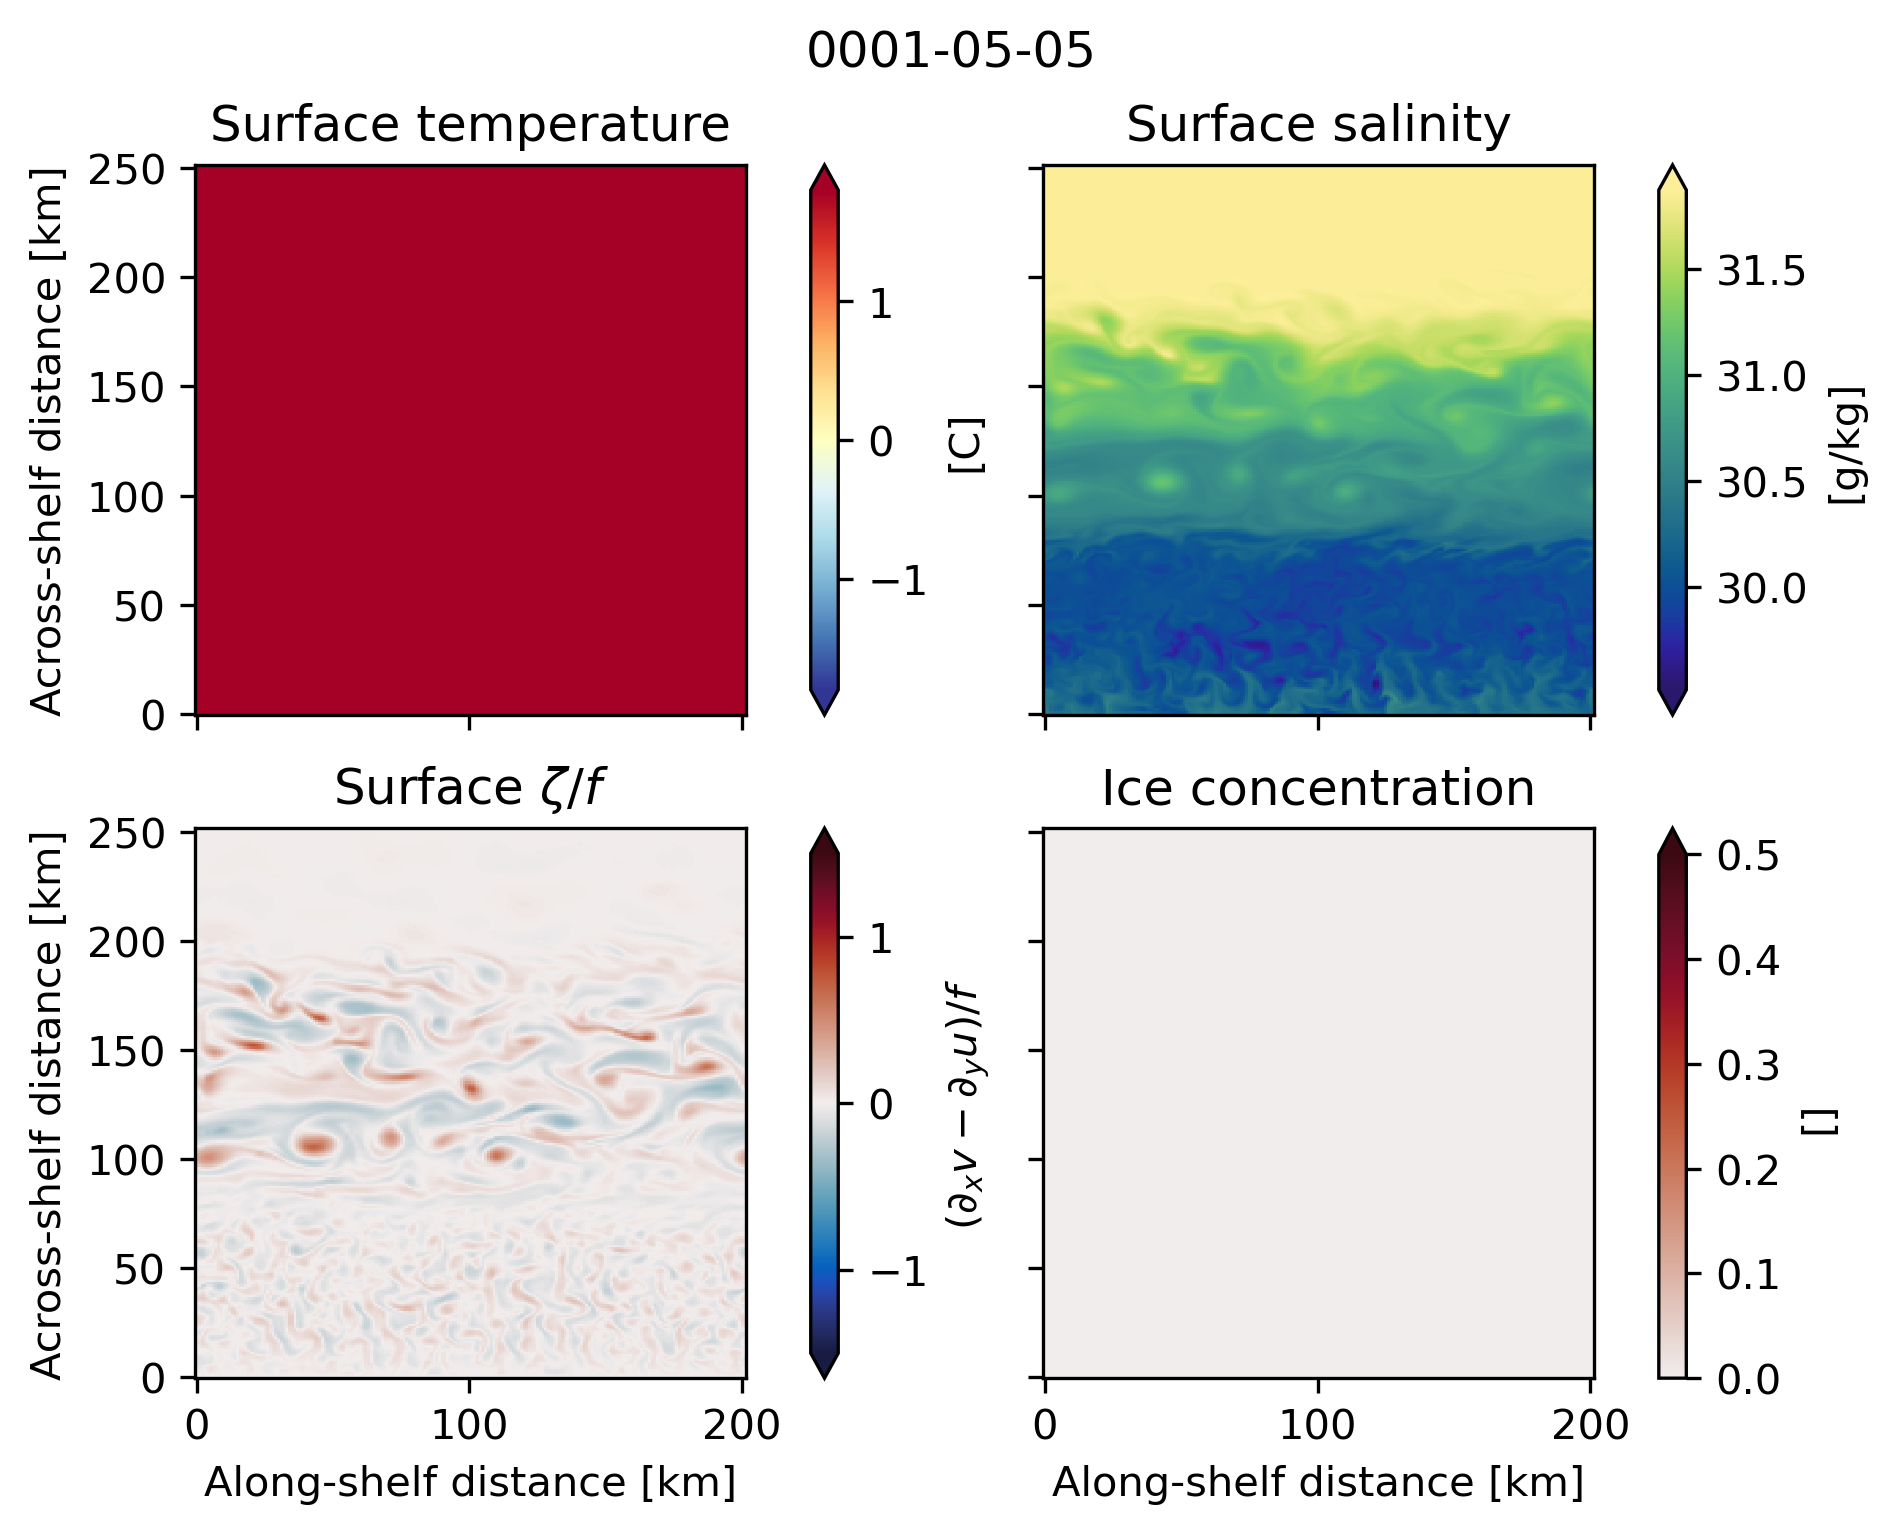

In [11]:
tidx = -1 
temp = ds.temp[tidx,-1]
salt = ds.salt[tidx,-1]
zeta = rv[tidx,-1]
aice = ds.Aice[tidx]

nrows = 2; ncols = 2
fig, ax = plt.subplots(nrows, ncols, figsize=((9.75/3)*1.9, 5),
                       constrained_layout=True, 
                       sharex=True, sharey=True, dpi=300)


# Temperature
m = ax[0,0].pcolormesh(xrho, yrho, temp, cmap='RdYlBu_r', vmin = -1.8, vmax = 1.8)
fig.colorbar(m, ax=ax[0,0], label='[C]', extend='both')

# Salinity
m1 = ax[0,1].pcolormesh(xrho, yrho, salt, cmap=cmo.haline)
fig.colorbar(m1, ax=ax[0,1], label='[g/kg]', extend='both')

# Relative vorticity
m2 = ax[1,0].pcolormesh(xrho, yrho, zeta, cmap=cmo.balance,
                      vmin = -1.5, vmax = 1.5)
fig.colorbar(m2, ax=ax[1,0], label='$(\partial_x v - \partial_y u)/f$', extend='both')

# Ice area fraction, aka concentration
m3 = ax[1,1].pcolormesh(xrho, yrho, aice, cmap=cmo.amp,
                      vmin = 0, vmax = 0.5)
fig.colorbar(m3, ax=ax[1,1], label='[]', extend='max')

# Set consistent axis limits
for i in range(nrows):
    for j in range(ncols):
        ax[i,j].set_xlabel('Along-shelf distance [km]')
        ax[i,j].set_aspect(0.8)

ax[0,0].set_ylabel('Across-shelf distance [km]')
ax[1,0].set_ylabel('Across-shelf distance [km]')
ax[0,0].set_title('Surface temperature')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[0,1].set_title('Surface salinity')
ax[1,0].set_title(r'Surface $\zeta/f$')
ax[1,1].set_title(r'Ice concentration')
fig.suptitle(str(ds.ocean_time.values[tidx])[:10])


In [ ]:
def plot_frame(tidx):

    nrows = 2; ncols = 2
    fig, ax = plt.subplots(nrows, ncols, figsize=((9.75/3)*1.9, 5),
                        constrained_layout=True, 
                        sharex=True, sharey=True, dpi=300)

    i = tidx // 1
    temp = ds.temp[tidx,-1]
    salt = ds.salt[tidx,-1]
    zeta = rv[tidx,-1]
    aice = ds.Aice[tidx]
    # Temperature
    m = ax[0,0].pcolormesh(xrho, yrho, temp, cmap='RdYlBu_r', vmin = -1.8, vmax = 1.8)
    fig.colorbar(m, ax=ax[0,0], label='[C]', extend='both')

    # Salinity
    m1 = ax[0,1].pcolormesh(xrho, yrho, salt, cmap=cmo.haline)
    fig.colorbar(m1, ax=ax[0,1], label='[g/kg]', extend='both')

    # Relative vorticity
    m2 = ax[1,0].pcolormesh(xrho, yrho, zeta, cmap=cmo.balance,
                        vmin = -1.5, vmax = 1.5)
    fig.colorbar(m2, ax=ax[1,0], label='$(\partial_x v - \partial_y u)/f$', extend='both')

    # Ice area fraction, aka concentration
    m3 = ax[1,1].pcolormesh(xrho, yrho, aice, cmap=cmo.amp,
                        vmin = 0, vmax = 0.5)
    fig.colorbar(m3, ax=ax[1,1], label='[]', extend='max')

    # Set consistent axis limits
    for j in range(nrows):
        for k in range(ncols):
            ax[j,k].set_xlabel('Along-shelf distance [km]')
            ax[j,k].set_aspect(0.8)

    ax[0,0].set_ylabel('Across-shelf distance [km]')
    ax[1,0].set_ylabel('Across-shelf distance [km]')
    ax[0,0].set_title('Surface temperature')
    ax[0,0].set_xlabel('')
    ax[0,1].set_xlabel('')
    ax[0,1].set_title('Surface salinity')
    ax[1,0].set_title(r'Surface $\zeta/f$')
    ax[1,1].set_title(r'Ice concentration')
    fig.suptitle(str(ds.ocean_time.values[tidx])[:10])

        # Comment this out if you are printing a lot of frames... jupyter will be unhappy
    #print(f'/pscratch/sd/b/bundzis/Beaufort_ROMS_idealized_jet_scratch/Movies/Surf_temp_salt_vort_ice/Plots01/surf_temp_salt_relvort_iceconc_og_nowinds_wdvd_{i}.png')
   
    plt.savefig(
        f'/pscratch/sd/b/bundzis/Beaufort_ROMS_idealized_jet_scratch/Movies/Surf_temp_salt_vort_ice/Plots01/surf_temp_salt_relvort_iceconc_og_nowinds_wdvd_{i}.png',
        dpi=200, bbox_inches='tight'
    )
    plt.close(fig)  # Close to avoid memory leaks

# Run 8 plots in parallel at once (adjust n_jobs based on your CPU). If you did this on a compute node you can set it to be 128!!
Parallel(n_jobs=4)(delayed(plot_frame)(tidx) for tidx in range(0, len(ds.ocean_time), 1))
